<a href="https://colab.research.google.com/github/yaminigangu/XAI_lab_pratical/blob/main/XAI_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost tensorflow keras shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=285e6f63027abf5d6120ff997f38eaadc6230d4b4837509d7a30c5e39f9eef92
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
!pip install lime

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression # Added import
from sklearn.tree import DecisionTreeClassifier # Added import
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Added import
from sklearn.svm import SVC # Added import
from sklearn.neighbors import KNeighborsClassifier # Added import
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

1 . Exploratory Data Analysis (EDA)

Dataset Shape: (50000, 11)

First 5 rows:
   patient_id  age  gender  pack_years radon_exposure asbestos_exposure  \
0      100000   69    Male   66.025244           High                No   
1      100001   32  Female   12.780800           High                No   
2      100002   89  Female    0.408278         Medium               Yes   
3      100003   78  Female   44.065232            Low                No   
4      100004   38  Female   44.432440         Medium               Yes   

  secondhand_smoke_exposure copd_diagnosis alcohol_consumption family_history  \
0                        No            Yes            Moderate             No   
1                       Yes            Yes            Moderate            Yes   
2                       Yes            Yes                 NaN             No   
3                       Yes             No            Moderate             No   
4                        No            Yes                 NaN            Yes   

  lung_cancer  
0   

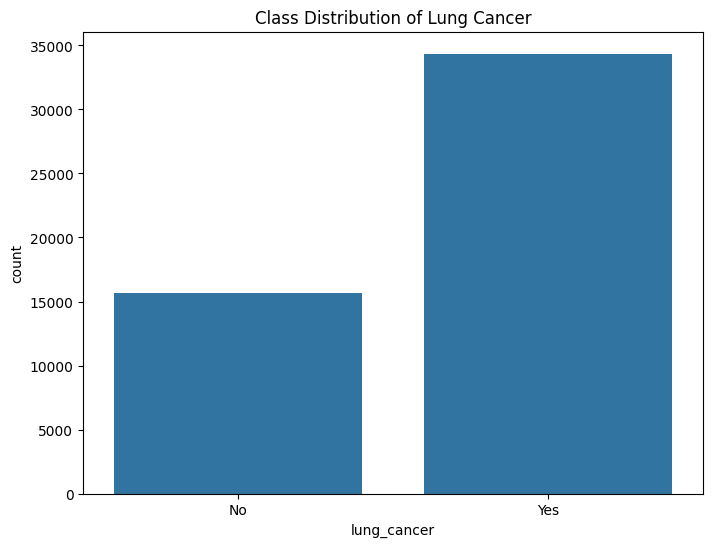


Unique values in each column:
patient_id: [100000 100001 100002 ... 149997 149998 149999]
age: [ 69  32  89  78  38 100  92  41  20  39  70  19  47  55  81  77  50  93
  75  66  76  59  97  79  64  68  72  24  90  56  35  21  31  26  88  61
  25  52  95  98  53  67  23  71  80  51  91  65  57  99  43  58  46  62
  82  18  28  22  45  29  40  54  44  96  94  60  30  49  83  74  87  73
  36  85  34  86  33  37  84  48  42  63  27]
gender: ['Male' 'Female']
pack_years: [66.02524418 12.78080002  0.4082781  ... 14.34972227 87.01255504
 37.59685057]
radon_exposure: ['High' 'Medium' 'Low']
asbestos_exposure: ['No' 'Yes']
secondhand_smoke_exposure: ['No' 'Yes']
copd_diagnosis: ['Yes' 'No']
alcohol_consumption: ['Moderate' nan 'Heavy']
family_history: ['No' 'Yes']
lung_cancer: ['No' 'Yes']


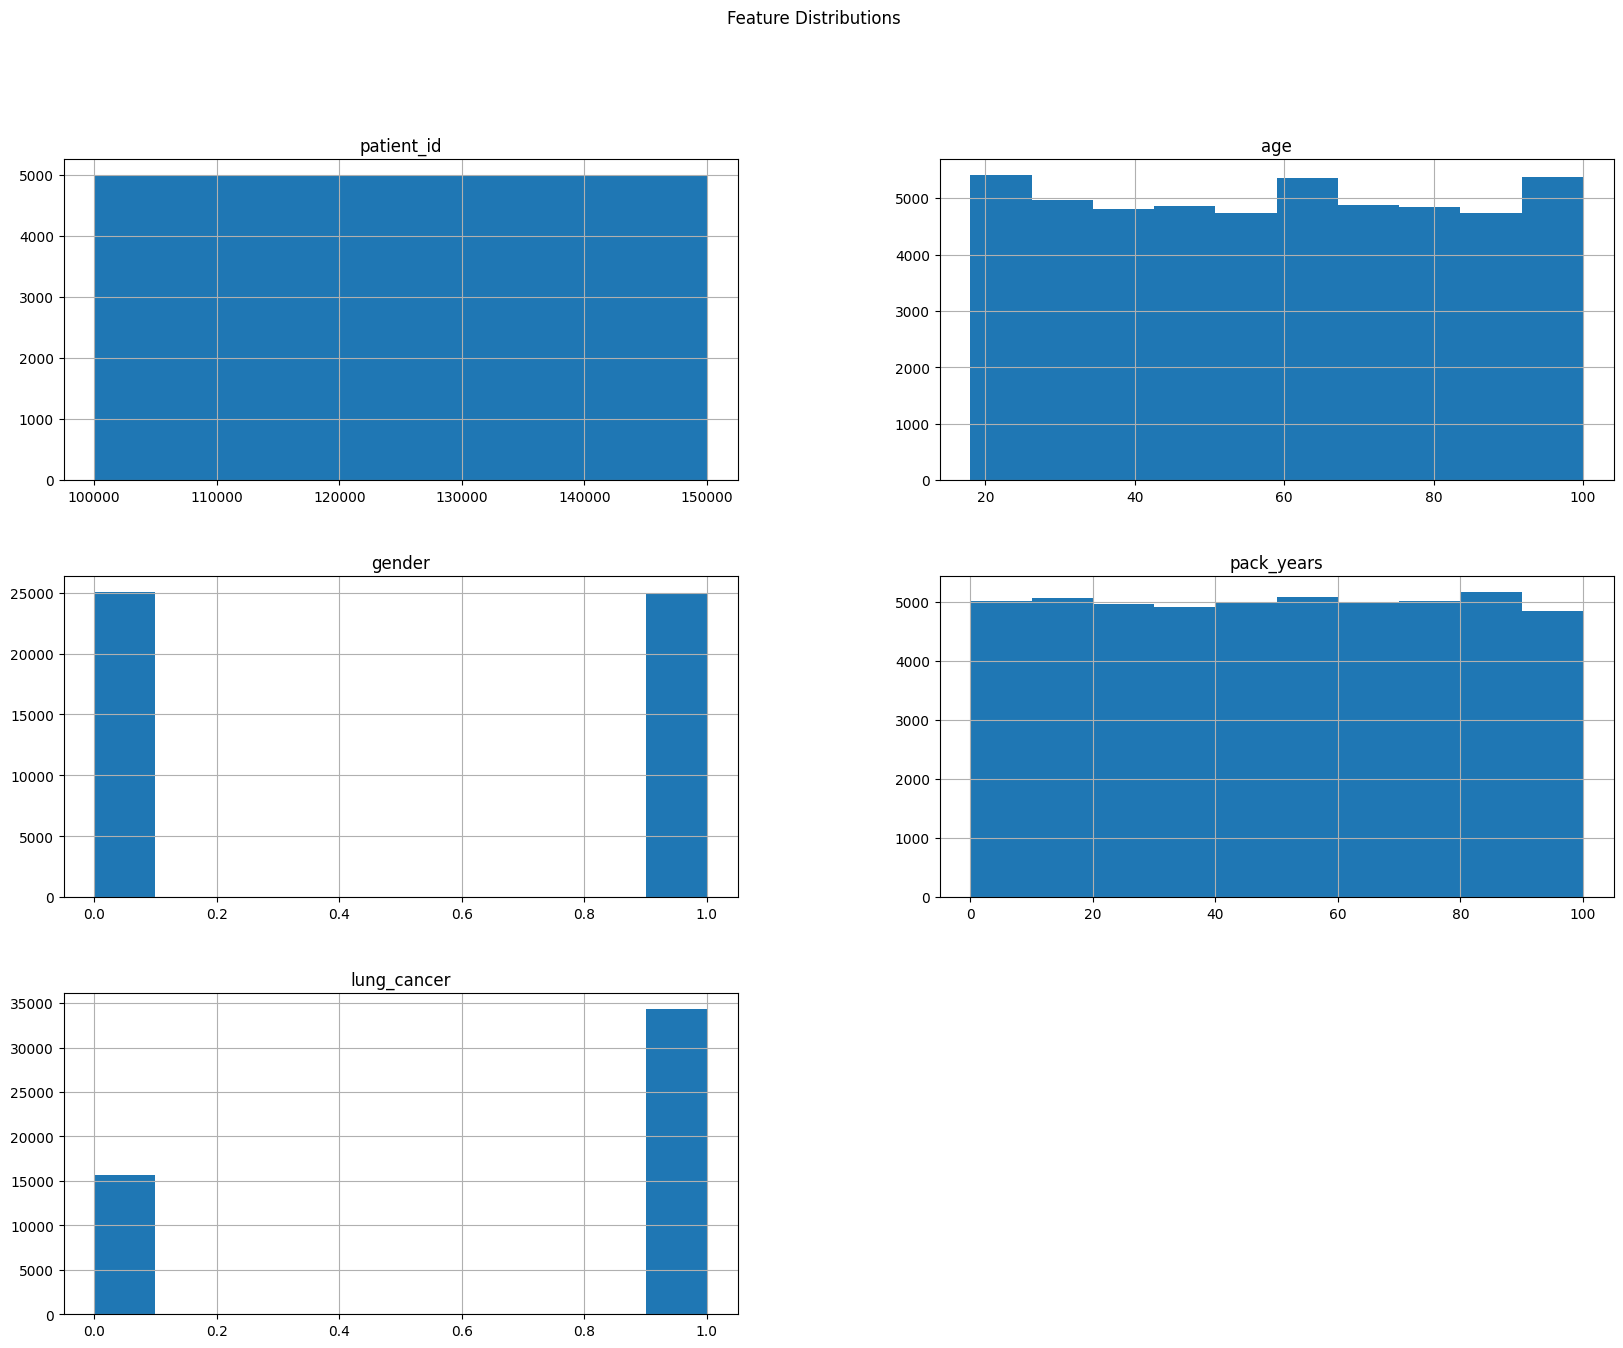

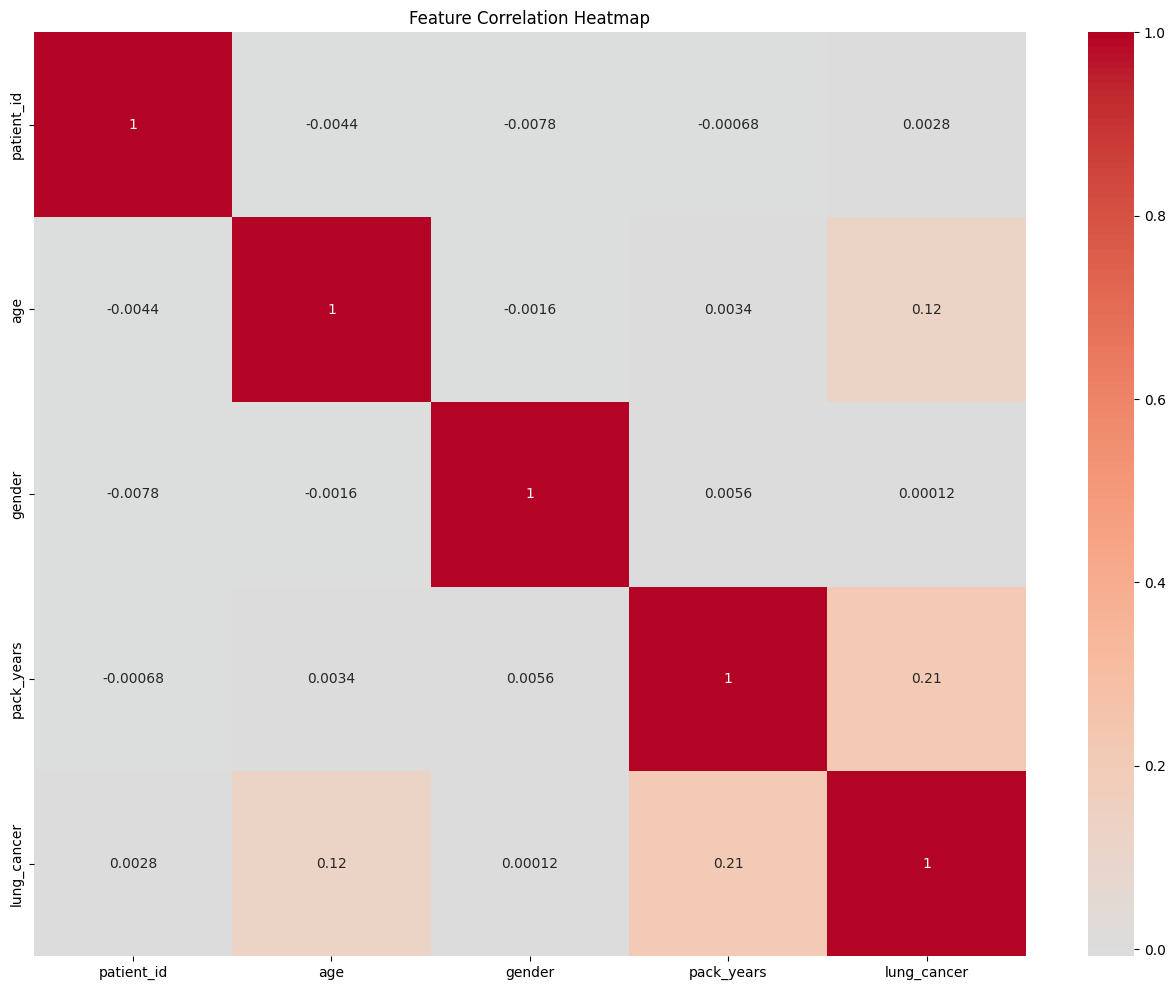


Correlation with Target (lung_cancer):
lung_cancer    1.000000
pack_years     0.210301
age            0.120938
patient_id     0.002812
gender         0.000122
Name: lung_cancer, dtype: float64


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/lung_cancer_dataset.csv')  # Update with your file path

# Inspect the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Check for class imbalance in the target variable
print("\nTarget Variable Distribution:")
print(df['lung_cancer'].value_counts()) # Changed from 'Patient_Status' to 'lung_cancer'
plt.figure(figsize=(8, 6))
sns.countplot(x='lung_cancer', data=df) # Changed from 'Patient_Status' to 'lung_cancer'
plt.title('Class Distribution of Lung Cancer') # Changed title
plt.show()

# Convert categorical variables to numerical (if needed)
# The dataset appears to have categorical variables that need encoding
print("\nUnique values in each column:")
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

# Convert categorical variables to numerical
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0}) # Ensure mapping is correct for Gender
df['lung_cancer'] = df['lung_cancer'].map({'Yes': 1, 'No': 0}) # Encode lung_cancer

# Visualize distributions of features
df.hist(figsize=(20, 15))
plt.suptitle('Feature Distributions')
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
# Drop non-numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

# Check correlation with target
print("\nCorrelation with Target (lung_cancer):")
print(corr_matrix['lung_cancer'].sort_values(ascending=False)) # Changed from 'Patient_Status' to 'lung_cancer'

2. Preprocessing

In [ ]:
# Separate features and target
# Remove rows with missing values in the target variable
df.dropna(subset=['lung_cancer'], inplace=True)
X = df.drop('lung_cancer', axis=1)
y = df['lung_cancer']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

# Handle missing values in numerical columns
imputer_numerical = SimpleImputer(strategy='mean')
X[numerical_cols] = imputer_numerical.fit_transform(X[numerical_cols])

# Handle missing values in categorical columns
imputer_categorical = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = imputer_categorical.fit_transform(X[categorical_cols])

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features (all features are now numerical after one-hot encoding)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_resampled))

# Create dataframes for the resampled data
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

Before SMOTE: [12509 27491]
After SMOTE: [27491 27491]


3. Machine Learning Models

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7267, Precision: 0.7499, Recall: 0.9037, F1: 0.8197, ROC-AUC: 0.7425
--------------------------------------------------
Training Decision Tree...
Decision Tree Results:
Accuracy: 0.6472, Precision: 0.7474, Recall: 0.7352, F1: 0.7412, ROC-AUC: 0.5945
--------------------------------------------------
Training Random Forest...
Random Forest Results:
Accuracy: 0.7178, Precision: 0.7625, Recall: 0.8561, F1: 0.8066, ROC-AUC: 0.7323
--------------------------------------------------
Training SVM...
SVM Results:
Accuracy: 0.6873, Precision: 0.6873, Recall: 1.0000, F1: 0.8147, ROC-AUC: 0.5441
--------------------------------------------------
Training KNN...
KNN Results:
Accuracy: 0.6632, Precision: 0.7184, Recall: 0.8386, F1: 0.7739, ROC-AUC: 0.5913
--------------------------------------------------
Training Gradient Boosting...
Gradient Boosting Results:
Accuracy: 0.7430, Precision: 0.7628, Recall: 0.9086, F1: 0.8293, R

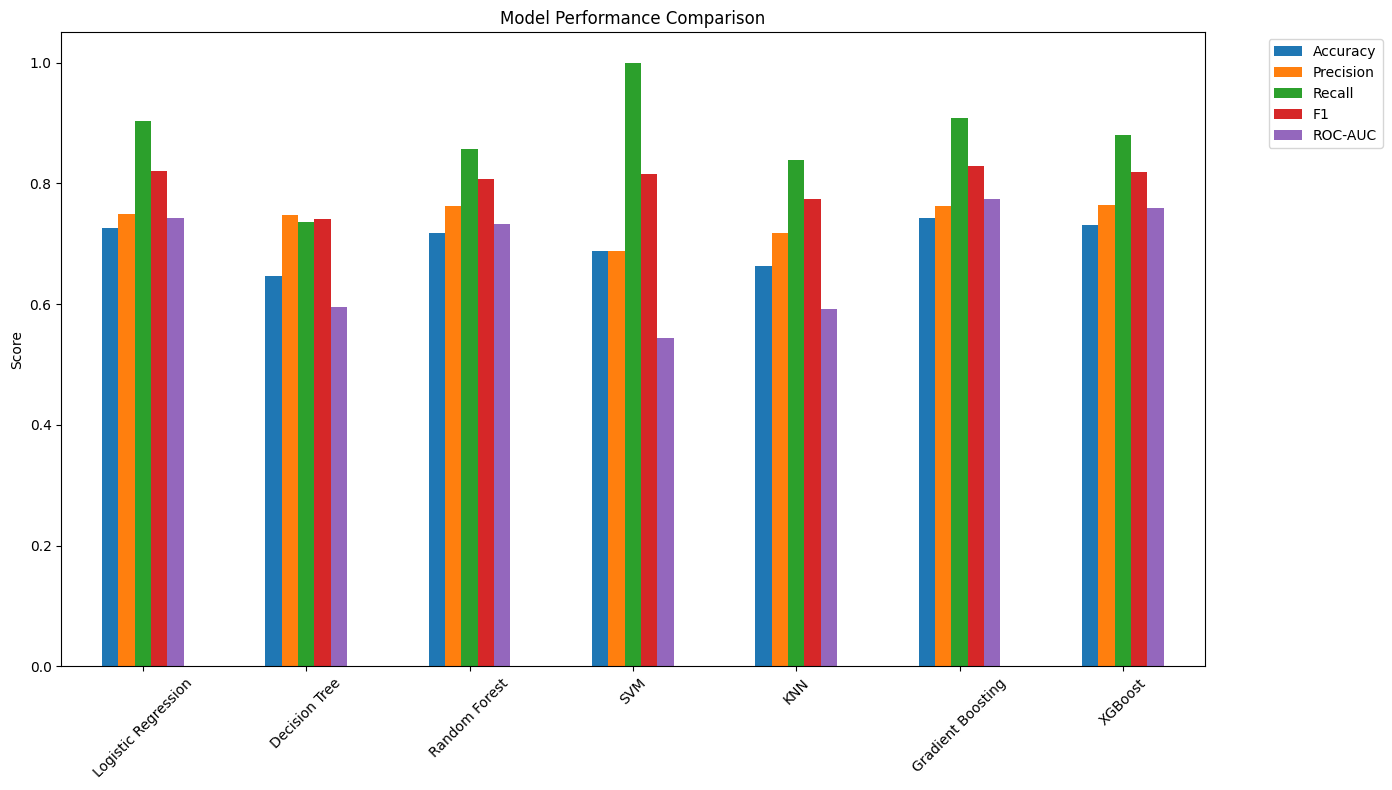

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(random_state=42, probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": roc_auc
    }

    # Format roc_auc for printing
    roc_auc_formatted = f"{roc_auc:.4f}" if roc_auc is not None else 'N/A'

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc_formatted}")
    print("-" * 50)

# Create a comparison DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot performance comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
results_df[metrics].plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

4. Deep Learning Models

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MLP Accuracy: 0.7311
MLP F1 Score: 0.8105
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Accuracy: 0.7341
CNN F1 Score: 0.8164
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Accuracy: 0.7196
LSTM F1 Score: 0.8081
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Hybrid CNN+LSTM Accuracy: 0.7049
Hybrid CNN+LSTM F1 Score: 0.7917
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Autoencoder+Classifier Accuracy: 0.7336
Autoencoder+Classifier F1 Score: 0.8197

Deep Learning Models Performance:
                        Accuracy        F1
MLP                       0.7311  0.810540
CNN                       0.7341  0.816431
LSTM                      0.7196  0.808050
Hybrid CNN+LSTM           0.7049  0.791670
Autoencoder+Classifier    0.7336  0.819683


<Figure size 1000x600 with 0 Axes>

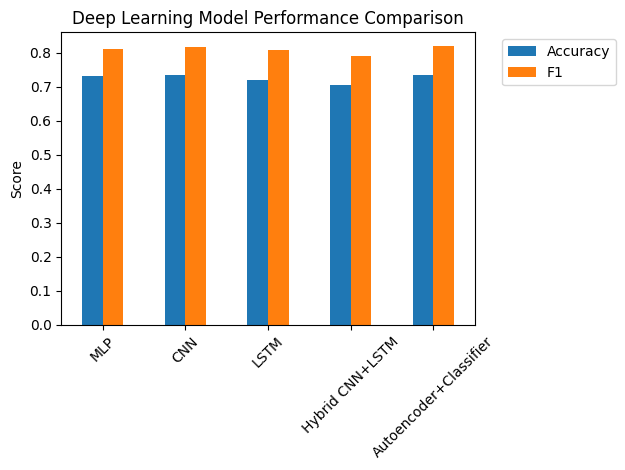

In [ ]:
# Convert data to numpy arrays for DL models
X_train_dl = X_train_resampled
X_test_dl = X_test_scaled
y_train_dl = y_train_resampled
y_test_dl = y_test.values

# 1. Multi-Layer Perceptron (MLP)
mlp_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_dl.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_history = mlp_model.fit(X_train_dl, y_train_dl, epochs=50, batch_size=32,
                            validation_split=0.2, verbose=0)

# Evaluate MLP
mlp_pred = (mlp_model.predict(X_test_dl) > 0.5).astype(int)
mlp_accuracy = accuracy_score(y_test_dl, mlp_pred)
mlp_f1 = f1_score(y_test_dl, mlp_pred)

print(f"MLP Accuracy: {mlp_accuracy:.4f}")
print(f"MLP F1 Score: {mlp_f1:.4f}")

# 2. 1D CNN
# Reshape data for CNN (samples, timesteps, features)
X_train_cnn = X_train_dl.reshape(X_train_dl.shape[0], X_train_dl.shape[1], 1)
X_test_cnn = X_test_dl.reshape(X_test_dl.shape[0], X_test_dl.shape[1], 1)

cnn_model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_cnn, y_train_dl, epochs=50, batch_size=32,
                            validation_split=0.2, verbose=0)

# Evaluate CNN
cnn_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
cnn_accuracy = accuracy_score(y_test_dl, cnn_pred)
cnn_f1 = f1_score(y_test_dl, cnn_pred)

print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print(f"CNN F1 Score: {cnn_f1:.4f}")

# 3. RNN with LSTM
lstm_model = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train_dl.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_cnn, y_train_dl, epochs=50, batch_size=32,
                              validation_split=0.2, verbose=0)

# Evaluate LSTM
lstm_pred = (lstm_model.predict(X_test_cnn) > 0.5).astype(int)
lstm_accuracy = accuracy_score(y_test_dl, lstm_pred)
lstm_f1 = f1_score(y_test_dl, lstm_pred)

print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
print(f"LSTM F1 Score: {lstm_f1:.4f}")

# 4. Hybrid CNN + LSTM (Optional)
hybrid_model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_dl.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hybrid_history = hybrid_model.fit(X_train_cnn, y_train_dl, epochs=50, batch_size=32,
                                  validation_split=0.2, verbose=0)

# Evaluate Hybrid
hybrid_pred = (hybrid_model.predict(X_test_cnn) > 0.5).astype(int)
hybrid_accuracy = accuracy_score(y_test_dl, hybrid_pred)
hybrid_f1 = f1_score(y_test_dl, hybrid_pred)

print(f"Hybrid CNN+LSTM Accuracy: {hybrid_accuracy:.4f}")
print(f"Hybrid CNN+LSTM F1 Score: {hybrid_f1:.4f}")

# 5. Autoencoder + Classifier
# Autoencoder
input_layer = layers.Input(shape=(X_train_dl.shape[1],))
encoded = layers.Dense(32, activation='relu')(input_layer)
encoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(X_train_dl.shape[1], activation='sigmoid')(decoded)

autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_train_dl, X_train_dl, epochs=50, batch_size=32,
                validation_split=0.2, verbose=0)

# Encoder for feature extraction
encoder = keras.Model(input_layer, encoded)

# Get encoded features
X_train_encoded = encoder.predict(X_train_dl)
X_test_encoded = encoder.predict(X_test_dl)

# Classifier on encoded features
classifier = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(16,)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier.fit(X_train_encoded, y_train_dl, epochs=50, batch_size=32,
                                    validation_split=0.2, verbose=0)

# Evaluate Autoencoder + Classifier
ae_pred = (classifier.predict(X_test_encoded) > 0.5).astype(int)
ae_accuracy = accuracy_score(y_test_dl, ae_pred)
ae_f1 = f1_score(y_test_dl, ae_pred)

print(f"Autoencoder+Classifier Accuracy: {ae_accuracy:.4f}")
print(f"Autoencoder+Classifier F1 Score: {ae_f1:.4f}")

# Compare DL models
dl_results = {
    'MLP': {'Accuracy': mlp_accuracy, 'F1': mlp_f1},
    'CNN': {'Accuracy': cnn_accuracy, 'F1': cnn_f1},
    'LSTM': {'Accuracy': lstm_accuracy, 'F1': lstm_f1},
    'Hybrid CNN+LSTM': {'Accuracy': hybrid_accuracy, 'F1': hybrid_f1},
    'Autoencoder+Classifier': {'Accuracy': ae_accuracy, 'F1': ae_f1}
}

dl_results_df = pd.DataFrame(dl_results).T
print("\nDeep Learning Models Performance:")
print(dl_results_df)

# Plot DL model comparison
plt.figure(figsize=(10, 6))
dl_results_df.plot(kind='bar')
plt.title('Deep Learning Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

5. Explainable AI (XAI)

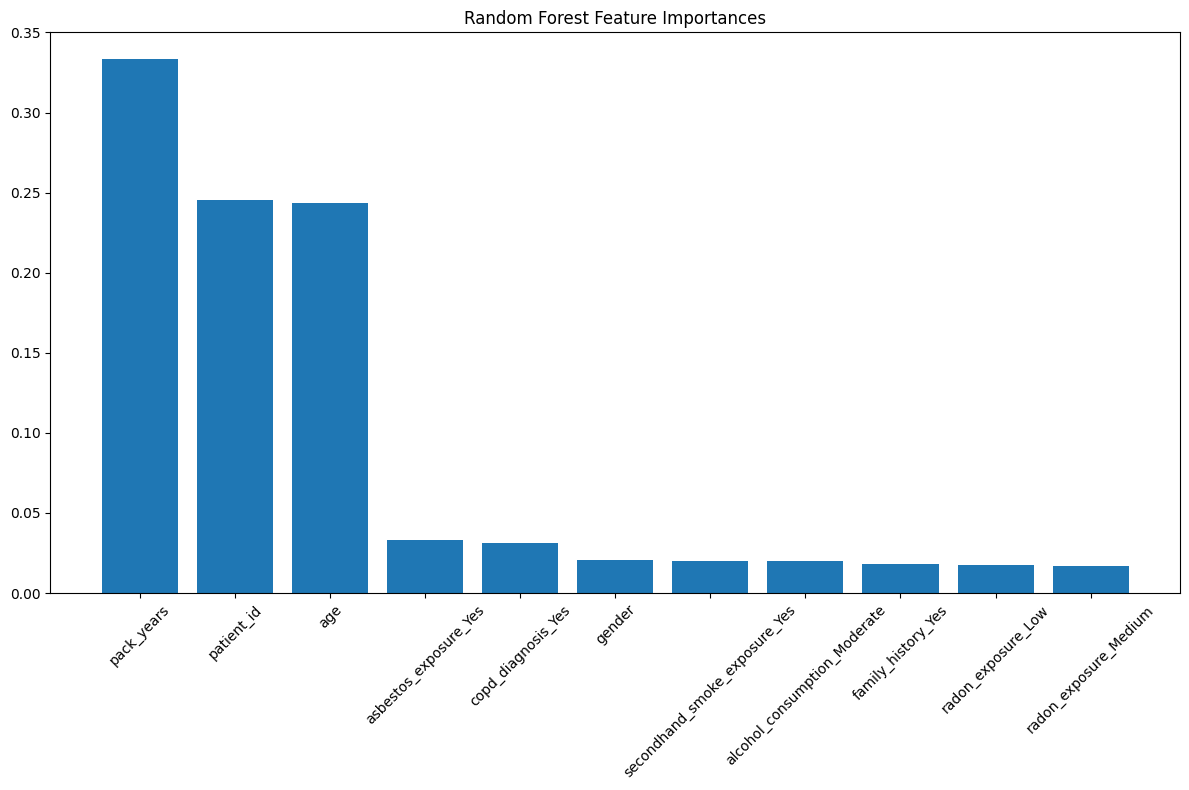

In [ ]:
# Feature Importance with Tree-based models
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# SHAP values for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled_df)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# SHAP values for Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

# Create a SHAP explainer for the linear model
explainer_lr = shap.LinearExplainer(lr_model, X_train_resampled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled_df)

# Summary plot for Logistic Regression
shap.summary_plot(shap_values_lr, X_test_scaled_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# SHAP for DL model (MLP)
# Create a SHAP explainer for the MLP model
def mlp_predict(data):
    return mlp_model.predict(data).flatten()

explainer_mlp = shap.KernelExplainer(mlp_predict, X_train_resampled[:100])
shap_values_mlp = explainer_mlp.shap_values(X_test_scaled_df.iloc[:50, :])

# Summary plot for MLP
shap.summary_plot(shap_values_mlp, X_test_scaled_df.iloc[:50, :], show=False)
plt.tight_layout()
plt.show()

# LIME for local explanations
# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_resampled,
    feature_names=X.columns,
    class_names=['Dead', 'Alive'], # Assuming 0 is Dead and 1 is Alive based on previous mapping
    mode='classification'
)

# Example LIME explanation for a single instance
# Choose an instance from the test set to explain
instance_idx = 0 # You can change this index to explain different instances
instance = X_test_scaled_df.iloc[instance_idx]

# Get the explanation for the instance
explanation = explainer_lime.explain_instance(
    instance,
    lr_model.predict_proba, # Using Logistic Regression model for explanation
    num_features=5 # Number of features to show in the explanation
)

# Visualize the explanation
print(f"\nLIME Explanation for instance {instance_idx}:")
explanation.show_in_notebook(show_table=True, show_all=False)

# You can also get the explanation as a list of tuples
# print("\nLIME Explanation (as list):")
# print(explanation.as_list())

6. Comparative Analysis and Final Report

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Added GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Part 1: Data Loading and Preprocessing
print("Loading and preprocessing data...")

# Load dataset (assuming we have a medical dataset with features and target)
# For demonstration, let's create a synthetic dataset similar to medical data
def create_synthetic_medical_data(n_samples=1000):
    np.random.seed(42)
    age = np.random.normal(50, 15, n_samples)
    age = np.clip(age, 18, 90).astype(int)
    smoking = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
    bmi = np.random.normal(25, 5, n_samples)
    cholesterol = np.random.normal(200, 40, n_samples)
    blood_pressure = np.random.normal(120, 20, n_samples)
    diabetes = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
    family_history = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    physical_activity = np.random.normal(3, 1, n_samples)

    # Create a synthetic target variable based on features
    risk_score = (age * 0.1 + smoking * 0.3 + (bmi > 30) * 0.2 +
                 (cholesterol > 240) * 0.15 + (blood_pressure > 140) * 0.15 +
                 diabetes * 0.25 + family_history * 0.2 - physical_activity * 0.1)

    # Introduce randomness to ensure both classes are present
    risk_score = risk_score + np.random.normal(0, 5, n_samples) # Added noise

    risk_score = 1 / (1 + np.exp(-risk_score/10))  # Sigmoid to get probabilities
    target = (risk_score > 0.5).astype(int)

    data = pd.DataFrame({
        'Age': age,
        'Smoking': smoking,
        'BMI': bmi,
        'Cholesterol': cholesterol,
        'BloodPressure': blood_pressure,
        'Diabetes': diabetes,
        'FamilyHistory': family_history,
        'PhysicalActivity': physical_activity,
        'Risk': target
    })

    return data

# Create synthetic dataset
data = create_synthetic_medical_data(1000)

# Display basic info
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nDataset statistics:")
print(data.describe())

# Part 2: Exploratory Data Analysis (EDA)
print("\nPerforming EDA...")

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk', data=data)
plt.title('Distribution of Risk (Target Variable)')
plt.savefig('target_distribution.png')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# Feature distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(data.columns[:-1]):  # Exclude target
    sns.histplot(data[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

# Pairplot for top correlated features
top_features = corr_matrix['Risk'].abs().sort_values(ascending=False).index[1:5]  # Top 4 features
sns.pairplot(data[list(top_features) + ['Risk']], hue='Risk')
plt.suptitle('Pairplot of Top Features with Risk', y=1.02)
plt.savefig('pairplot_top_features.png')
plt.show()

# Part 3: Data Preprocessing for Modeling
print("\nPreprocessing data for modeling...")

# Separate features and target
X = data.drop('Risk', axis=1)
y = data['Risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for better handling
feature_names = X.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Part 4: Model Training and Evaluation
print("\nTraining and evaluating models...")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42) # Added Gradient Boosting
}

# Train and evaluate traditional ML models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]


    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }